In [46]:
import numpy as np
import pandas as pd
import xlrd
import math
import seaborn as sb
import matplotlib.pyplot as plt
from sys import float_info
%matplotlib inline

Y = 0
I = 1
C = 2
J = 3
E = 4
N = 5

In [83]:
def reading(files, prices):
    files[Y] = pd.read_excel('GDP_' + prices + '.xls')
    files[I] = pd.read_excel('Import_' + prices + '.xls')
    files[C] = pd.read_excel('Final_consumption_expenditure_' + prices + '.xls')
    files[J] = pd.read_excel('Gross_capital_formation_' + prices + '.xls')
    files[E] = pd.read_excel('Export_' + prices + '.xls')
    files[N] = pd.read_excel('Population.xls')
    return files

def number_to_column(number):
    if number == Y:
        return 'Y'
    elif number == I:
        return 'I'
    elif number == C:
        return 'C'
    elif number == J:
        return 'J'
    elif number == E:
        return 'E'
    elif number == N:
        return 'N'
    else:
        return str(number)
    
def upgrade_data(files):
    k = 0
    answer = pd.DataFrame(columns = ['date'])
    while k < 6:
        index = pd.Index(files[k]['Country Name'])
        i = index.get_loc('India')
        df = files[k].iloc[[i]]
        df = df.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
        name = number_to_column(k)
        df = pd.DataFrame.transpose(df)
        df.columns = [name]
        df['date'] = df.index
        if k == 0:
            answer['date'] = df['date']
        answer = pd.merge(answer, df, how='outer', on='date')
        if k == N:
            answer[name] = answer[name].dropna() / 1000000
        else:
            answer[name] = answer[name].dropna() / 1000000000
        k += 1
    answer.head(n=5)
    dates = {}
    for i in range(1960, 1970):
        dates[i - 1960] = str(i)
    answer = answer.drop(index=dates)
    answer = answer.dropna()
    return answer

def new_param_df(name, datedf):
    df = pd.DataFrame(columns = ['date', name])
    df['date'] = datedf['date']
    df.index = df['date']
    df = df.drop(columns=['date'])
    return df

def Theil_index(char, df, dt, dates, t0):
    numerator = pd.DataFrame(columns=['date', 'value']) 
    numerator['date'] = dt['date']
    if not dates.empty:
        numerator = numerator.drop(dates)
    numerator = numerator.drop(columns=['date'])
    numerator['value'] = (df[char + '_stat'] - df[char]) ** 2
    a = numerator['value'].rolling(2016-t0+1).sum()['2016']
    denominator = pd.DataFrame(columns=['date', 'value']) 
    denominator['date'] = dt['date']
    if not dates.empty:
        denominator = denominator.drop(dates)
    denominator = denominator.drop(columns=['date'])
    denominator['value'] = (df[char + '_stat']) ** 2 + (df[char]) ** 2
    b = denominator['value'].rolling(2016-t0+1).sum()['2016']
    #print ("a = ", a)
    #print ("b = ", b)
    answer = math.sqrt(a / b)
    return answer

def labor_force(lam, L_stat):
    L0 = 405 #http://data.trendeconomy.ru/dataviewer/wb/wbd/wdi?kf=WDI&time_period=2000&ref_area=IND&series=SL_TLF_TOTL_IN
    L = pd.DataFrame(columns = ['date', 'L', 'L_stat'])
    L['date'] = X_curr['date']
    L['date'] = pd.to_datetime(L['date'])
    L.index = L['date']
    L = L.drop(columns=['date'])
    dates=pd.date_range('1/1/1970', '1/1/1989', freq='AS')
    L = L.drop(dates)
    L['L'][str(t0)] = L0
    i = 1990
    while i <= 2016:
        L['L'][str(i) + '-01-01'] = L0 * (math.exp(lam * (i-t0)))
        i = i + 1
    L['L_stat'] = L_stat['L_stat'].fillna(0)
    return L

def precision(number):
    p = 0
    while (number < 1):
        p = p + 1
        number = number * 10.0
    return p
        

In [48]:
files_curr= {}
files_const = {}
files_curr = reading(files_curr, 'curr')
files_const = reading(files_const, 'const')

In [49]:
X_curr = upgrade_data(files_curr)
X_curr['date'] = pd.to_datetime(X_curr['date'], format="%Y")
X_curr.index = X_curr['date']
X_curr.head(n=1)

,date,Y,I,C,J,E,N
date,,,,,,,
1970-01-01,1970-01-01,461.923504,18.117348,409.40896,77.964782,17.657331,553.578513


In [50]:
X_const = upgrade_data(files_const)
X_const['date'] = pd.to_datetime(X_const['date'], format="%Y")
X_const.index = X_const['date']
X_const.head(n=1)

,date,Y,I,C,J,E,N
date,,,,,,,
1970-01-01,1970-01-01,9993.870692,475.341105,7918.583292,1818.757653,446.426193,553.578513


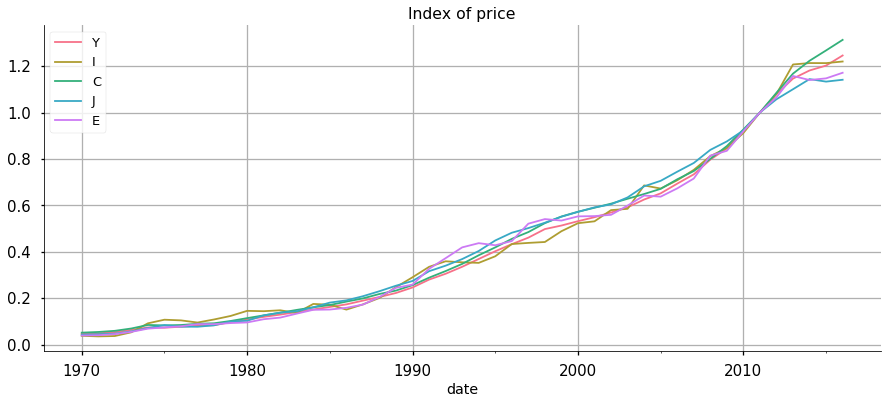

In [51]:
price_index = pd.DataFrame(columns = ['date', 'Y', 'I', 'C', 'J', 'E'])
price_index['date'] = X_curr['date']
i = 0
while i < 5:
    name = number_to_column(i)
    price_index[name] = X_curr[name] / X_const[name]
    i += 1
    
sb.set_context("talk", rc={"lines.linewidth": 3})
sb.set_palette("husl", 5)
price_index.index = price_index['date']
price_index = price_index.drop(columns=['date'])
fig = price_index.plot(figsize=(15, 6), title='Index of price', fontsize=15, linewidth=1.8)
fig.grid()
sb.despine()

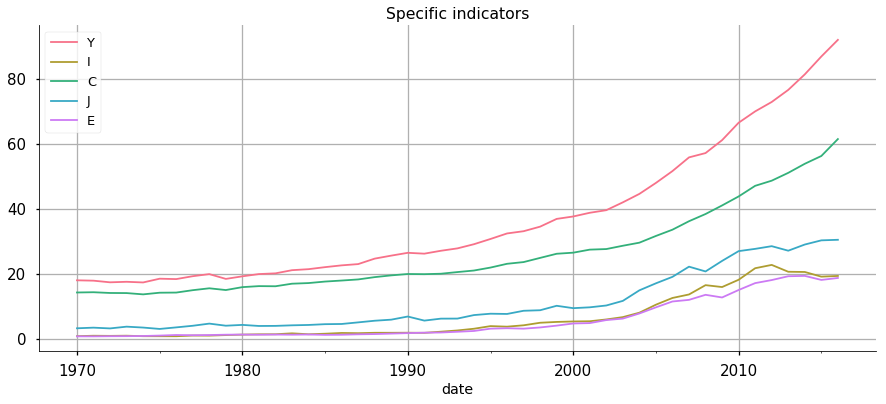

In [52]:
spec_ind = pd.DataFrame(columns = ['date', 'Y', 'I', 'C', 'J', 'E'])
spec_ind['date'] = X_curr['date']
i = 0
while i < 5:
    name = number_to_column(i)
    spec_ind[name] = X_const[name] / X_const['N']
    i += 1

spec_ind.index = spec_ind['date']
spec_ind = spec_ind.drop(columns=['date'])
figure = spec_ind.plot(figsize=(15, 6), title='Specific indicators', fontsize=15, linewidth=1.8)
figure.grid()
sb.despine()

Mean =  1.3940207994627265


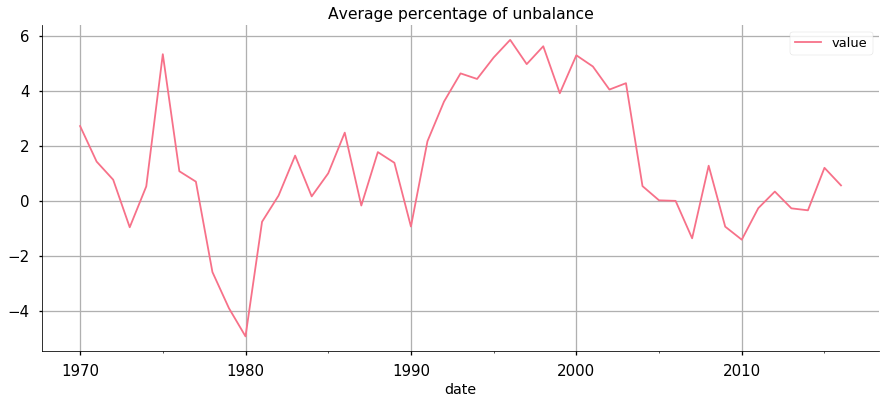

In [53]:
bal_per_curr = pd.DataFrame(columns = ['date', 'value'])
bal_per_curr['date'] = X_const['date']
bal_per_curr['value'] = ((X_const['Y'] + X_const['I']) - (X_const['C'] + X_const['J'] + X_const['E'])) / (X_const['Y'] + X_const['I']) * 100

bal_per_curr.index = bal_per_curr['date']
bal_per_curr = bal_per_curr.drop(columns=['date'])
figure = bal_per_curr.plot(figsize=(15, 6), title='Average percentage of unbalance', fontsize=15, linewidth=1.8)
figure.grid()
sb.despine()

print('Mean = ', bal_per_curr['value'].mean() )
#bal_per_curr.head(n=5)

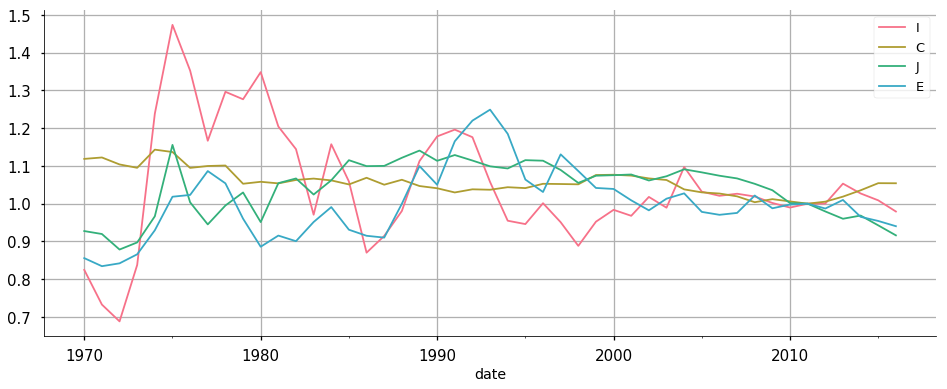

In [54]:
#относительные индексы цен π
pi = pd.DataFrame(columns = ['date', 'Y', 'I', 'C', 'J', 'E'])
pi['date'] = X_const['date']
pi.index = pi['date']
pi = pi.drop(columns=['date'])

i = 0
while i < 5:
    name = number_to_column(i)
    pi[name] = price_index[name] / price_index['Y']
    i += 1
    
pi = pi.drop(columns=['Y'])
figure = pi.plot(figsize=(16, 6), fontsize=15, linewidth=1.8)
figure.grid()
sb.despine()

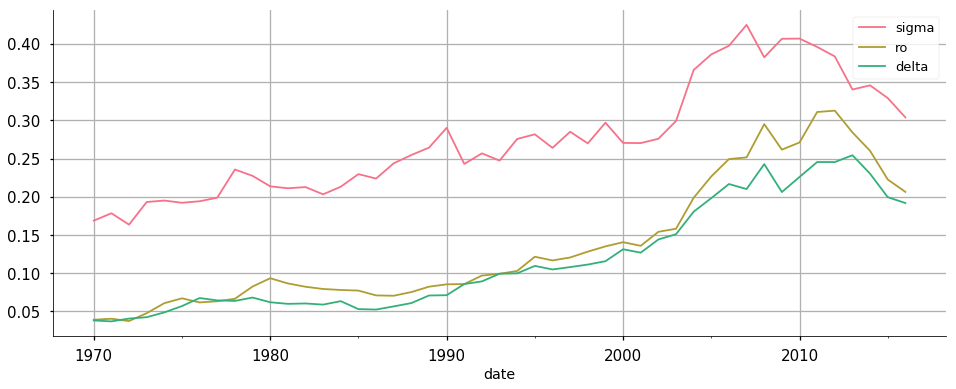

In [55]:
# параметры σ, δ, ρ
sigma0 = new_param_df('sigma', X_const)
delta0 = new_param_df('delta', X_const)
ro0 = new_param_df('ro', X_const)

sigma0['sigma'] = pi['J'] * X_const['J'] / (X_const['Y'])
delta0['delta'] = pi['E'] * X_const['E'] / X_const['Y']
ro0['ro'] = pi['I'] * X_const['I'] / (X_const['Y'])

figure = sigma0.plot(figsize=(16, 6), fontsize=15, linewidth=1.8)
ro0.plot(ax=figure, linewidth=1.8)
delta0.plot(ax=figure, linewidth=1.8)
figure.grid()
sb.despine()

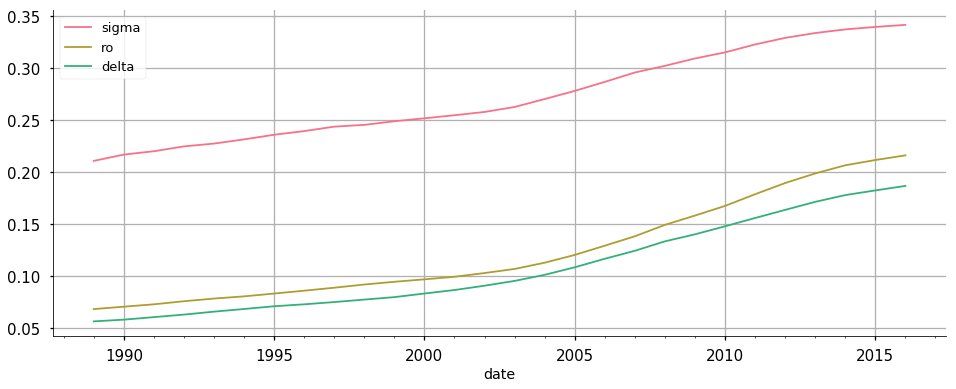

In [56]:
sigma = new_param_df('sigma', X_const)
delta = new_param_df('delta', X_const)
ro = new_param_df('ro', X_const)

sigma['sigma'] = sigma0['sigma'].rolling(20).mean().dropna()
delta['delta'] = delta0['delta'].rolling(20).mean().dropna()
ro['ro'] = ro0['ro'].rolling(20).mean().dropna()

figure = sigma.plot(figsize=(16, 6), fontsize=15, linewidth=1.8)
ro.plot(ax=figure, linewidth=1.8)
delta.plot(ax=figure, linewidth=1.8)
figure.grid()
sb.despine()

In [57]:
def sigma_f(t):
    ans = 0.005 * (t - 2010) + 0.315
    if ans > 0:
        return ans
    return 0

def delta_f(t):
    ans = 0.007 * (t - 2010) + 0.147
    if ans > 0:
        return ans
    return 0    

def ro_f(t):
    ans = 0.008 * (t - 2010) + 0.168
    if ans > 0:
        return ans
    return 0

In [58]:
f_sigma = new_param_df('f_sigma', X_const)
for i in range(2010, 2017):
    f_sigma['f_sigma'][str(i) + '-01-01'] = sigma_f(i)
    
f_delta = new_param_df('f_delta', X_const)
for i in range(2010, 2017):
    f_delta['f_delta'][str(i) + '-01-01'] = delta_f(i)
    
f_ro = new_param_df('f_ro', X_const)
for i in range(2010, 2017):
    f_ro['f_ro'][str(i) + '-01-01'] = ro_f(i)

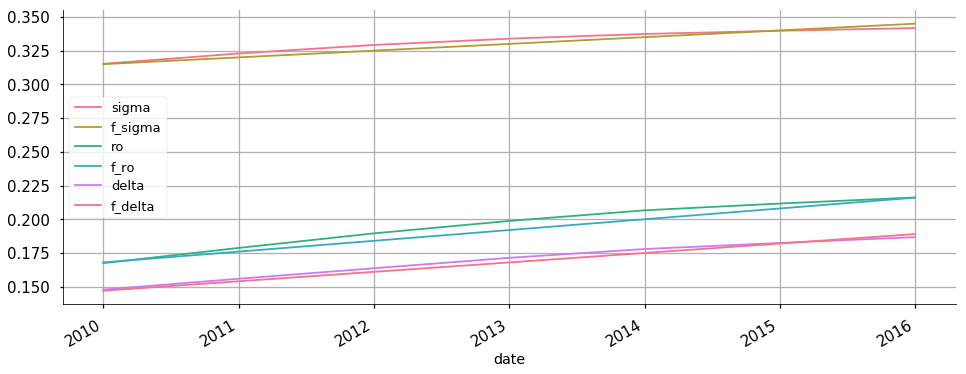

In [59]:
dates=pd.date_range('1/1/1989', '1/1/2009', freq='AS')
sigma1 = sigma.drop(dates)
ro1 = ro.drop(dates)
delta1 = delta.drop(dates)

figure = sigma1.plot(figsize=(16, 6), fontsize=15, linewidth=1.8)
f_sigma.plot(ax=figure, linewidth=1.8)

ro1.plot(ax=figure, linewidth=1.8)
f_ro.plot(ax=figure, linewidth=1.8)

delta1.plot(ax=figure, linewidth=1.8)
f_delta.plot(ax=figure, linewidth=1.8)

figure.grid()
sb.despine()

In [60]:
# Данные об экономически активном населении L_stat
L_stat = pd.read_excel('Economical_active_population.xlsx')
L_stat['date'] = pd.to_datetime(L_stat['date'], format='%Y')
L_stat.index = L_stat['date']
L_stat['L_stat'] = L_stat['value'] / 1000000
L_stat = L_stat.drop(columns=['value', 'date'])
#L_stat.head(n=5)

In [61]:
def find_lambda(t0, L_stat, X_curr):
    lam = 0.0
    fin_lam = 0.0
    index = float_info.max
    dates=pd.date_range('1/1/1970', '1/1/1989', freq='AS')

    while (lam < 0.5):
        L = labor_force(lam, L_stat)
        curr_index = Theil_index('L', L, X_curr, dates, t0)
        if curr_index < index:
                index = curr_index
                fin_lam = lam
        lam = lam + 0.005
    return fin_lam

lambda =  0.015


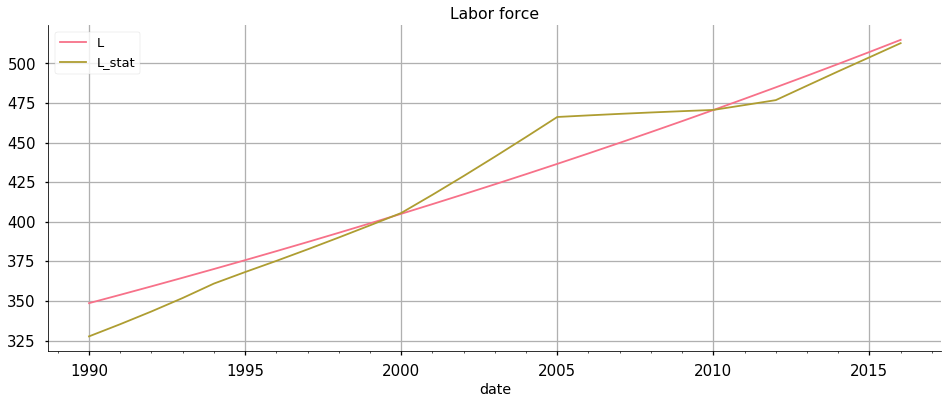

In [62]:
t0 = 2000
lam = find_lambda(t0, L_stat, X_curr)
L = labor_force(lam, L_stat)
print ('lambda = ', lam)
figure = L.plot(figsize=(16, 6), title='Labor force', fontsize=15, linewidth=1.8)
figure.grid()
sb.despine()

In [63]:
def find_K(df, mu):
    K = pd.DataFrame(columns = ['date', 'K'])
    K['date'] = df['date']
    K.index = K['date']
    K = K.drop(columns=['date'])
    
    K['K'] = df['J'] * (1 - mu)
    K['K']['1970'] = df['J'][str(1970)]
    K['K'] = K['K'].rolling(2).sum()
    K['K']['1970'] = df['J'][str(1970)]
    return K

def find_K0(t0, mu, df):
    i = 1970
    K0 = 0
    index = 0.0
    while(i <= t0):
        K0 = K0 + df['J'][str(i) + '-01-01'] * math.exp(-mu*(t0 - i))
        i = i + 1
    #kappa = K0 / df['Y'][str(t0) + '-01-01']
    #print ("kappa = ", kappa)
    return K0

def new_Y(mu, X_const, L_stat, lam, t0):
    Y = X_const
    Y = Y.drop(columns = ['date', 'I', 'C', 'J', 'E', 'N'])

    K = find_K(X_const, mu)
    K0 = find_K0(t0, mu, X_const)
    L = labor_force(lam, L_stat)
    L0 = L['L_stat'][str(t0) + '-01-01']
    Y['L'] = L['L'] / L0
    Y['K'] = K['K'] / K0
    Y['Y_stat'] = Y['Y']
    
    return Y

def find_a_b(X_const, t0, Y0, Y):
  
    dates=pd.date_range('1/1/1970', '1/1/1970', freq='AS')
    a = 0.1
    b = 0.5
    fin_b = 0.1
    fin_a = 0
    index = float_info.max
    while (b < 5):
        #print ("b = ", b)
        a = 0.1
        Y['Y_stat'] = X_const['Y']
        while (a < 1):
           # print ("a = ", a)
            Y['Y'] = ces(a, b, Y, Y0)
            curr_index = Theil_index('Y', Y, X_const, dates, t0)
            if curr_index < index:
                index = curr_index
                fin_a = a
                fin_b = b
            a = a + 0.01
        b = b + 1
    return fin_a, fin_b

In [64]:
mu = 0.03

In [65]:
def ces(a, b, Y, Y0):
    Y['Y'] = Y0 * ((a * ((Y['L'])**(-b)) + (1-a) * ((Y['K'])**(-b)))**(-1/b))
    return Y

0.1 4.5


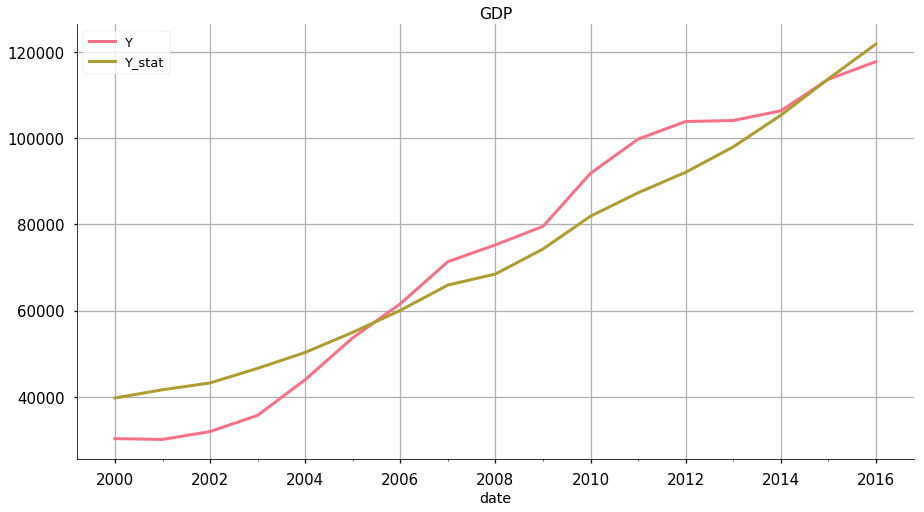

In [66]:
Y = new_Y(mu, X_const, L_stat, lam, t0)
Y0 = 4 * X_const['Y'][str(t0) + '-01-01']
a, b = find_a_b(X_const, t0, Y0, Y)
dates=pd.date_range('1/1/1970', '1/1/1999', freq='AS')
Y = Y.drop(dates)
print (a, b)

Y = ces(a, b, Y, Y0)
Y = Y.drop(columns = ['L', 'K'])
figure = Y.plot(figsize=(15, 8), title='GDP', fontsize=15)
figure.grid()
sb.despine()

In [67]:
def graph(df, cmp):
    figure1 = plt.figure(figsize=(20, 8))
    layout = (1, 4)
    fig_start = plt.subplot2grid(layout, (0, 0), colspan=2)
    fig_end = plt.subplot2grid(layout, (0, 2), colspan=2)
    cmp.plot(ax=fig_start, alpha=1)
    df.plot(ax=fig_end, alpha=1)
    sb.despine()
    fig_start.grid()
    fig_end.grid()

In [68]:
f_sigma = new_param_df('f_sigma', X_const)
for i in range(1970, 2017):
    f_sigma['f_sigma'][str(i) + '-01-01'] = sigma_f(i)
    
f_delta = new_param_df('f_delta', X_const)
for i in range(1970, 2017):
    f_delta['f_delta'][str(i) + '-01-01'] = delta_f(i)
    
f_ro = new_param_df('f_ro', X_const)
for i in range(1970, 2017):
    f_ro['f_ro'][str(i) + '-01-01'] = ro_f(i)

Экспорт E(t)

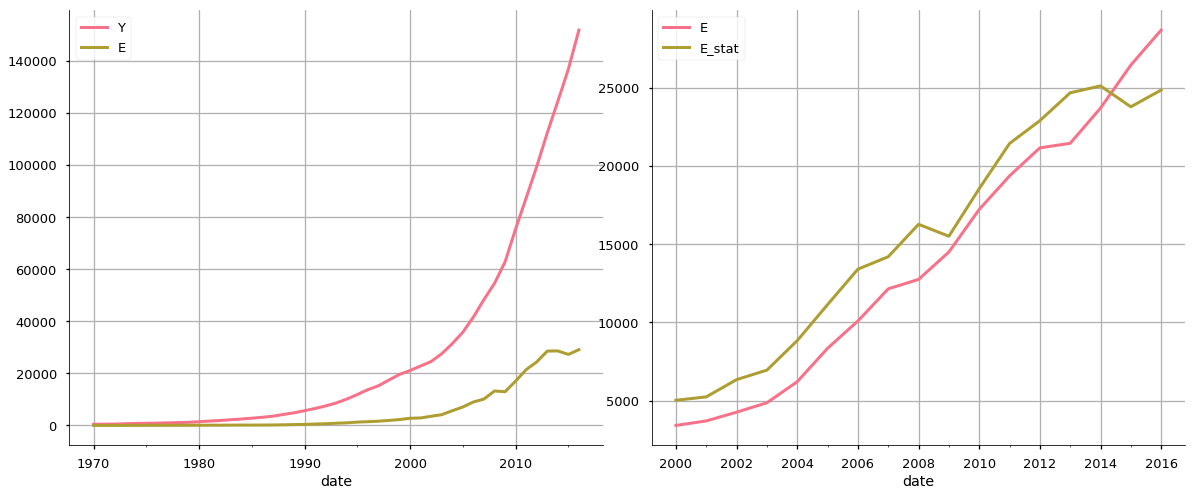

In [69]:
# Подбор аналитической функции E(t) = f(Y(t))
cmp = X_curr
cmp = cmp.drop(columns=['date', 'I', 'C', 'J', 'N'])

E = cmp
E = E.drop(columns=['Y'])
E['E'] = Y['Y'] * (0.04 + f_delta['f_delta']) / pi['E']
E['E_stat'] = X_const['E']
dates=pd.date_range('1/1/1970', '1/1/1999', freq='AS')
E = E.drop(dates)

graph(E, cmp)

Импорт I(t)

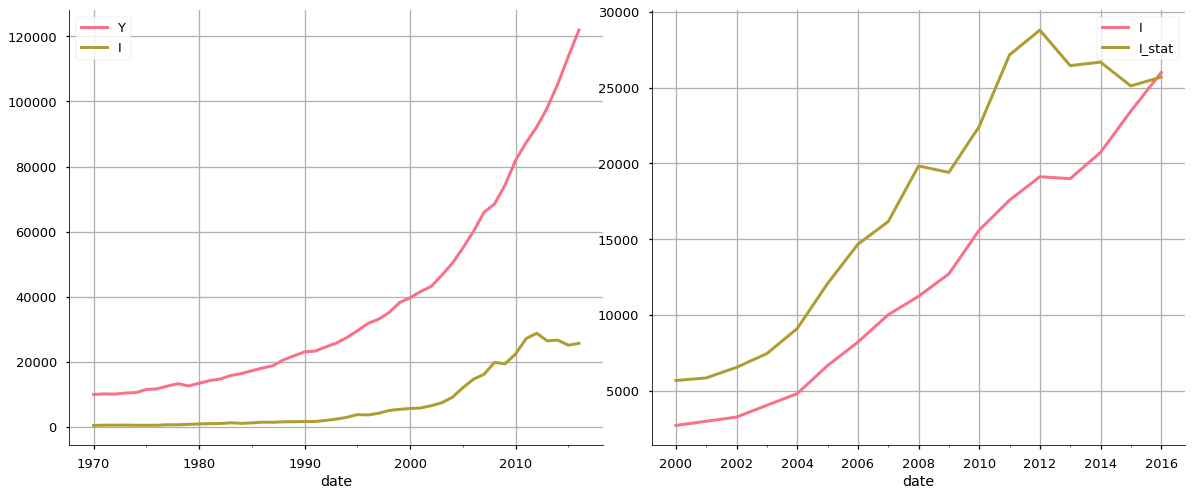

In [70]:
# Подбор аналитической функции I(t) = f(Y(t))

cmp = X_const
cmp = cmp.drop(columns=['date', 'C', 'J', 'E', 'N'])
I = cmp
I = I.drop(columns=['Y'])
I['I'] = Y['Y'] * f_ro['f_ro'] / pi['I']
I['I_stat'] = X_const['I']
dates=pd.date_range('1/1/1970', '1/1/1999', freq='AS')
I = I.drop(dates)

graph(I, cmp)

Инвестиции J(t)

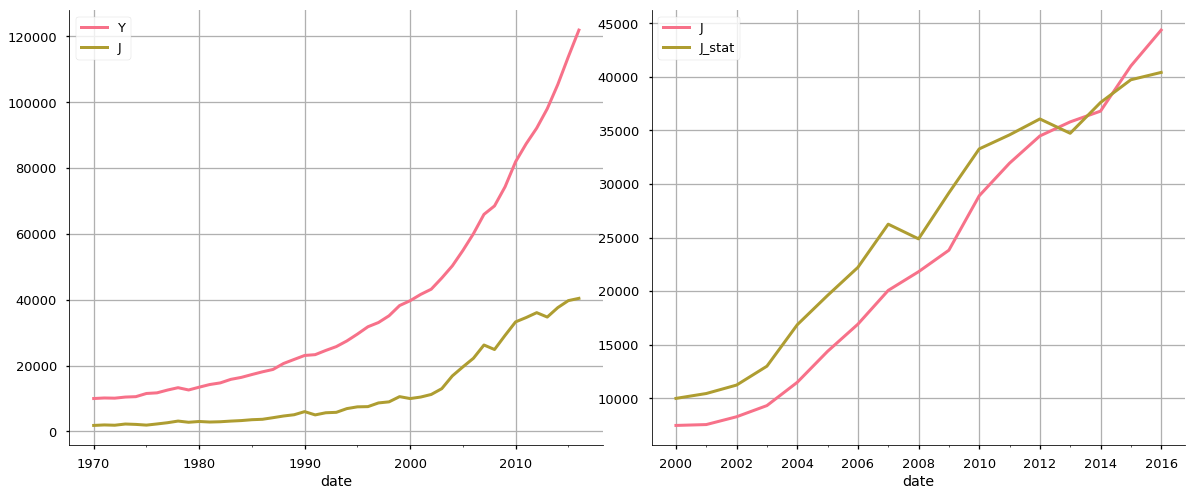

In [71]:
# Подбор аналитической функции J(t) = f(Y(t))

cmp = X_const
cmp = cmp.drop(columns=['date', 'E', 'I', 'C', 'N'])
J = cmp
J = J.drop(columns=['Y'])
J['J'] = Y['Y'] * f_sigma['f_sigma'] / pi['J']
J['J_stat'] = X_const['J']
dates=pd.date_range('1/1/1970', '1/1/1999', freq='AS')
J = J.drop(dates)
graph(J, cmp)

Потребление Q(t)

Theil index = 0.08682378197875236


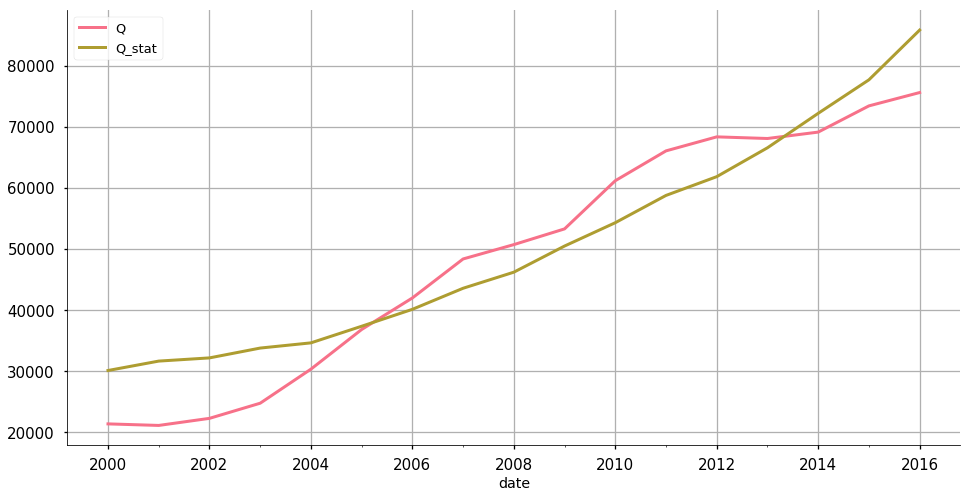

In [87]:
Q = pd.DataFrame(columns = ['date', 'Q'])
Q['date'] = X_const['date']
Q['date'] = pd.to_datetime(Q['date'])
Q.index = Q['date']
Q = Q.drop(columns=['date'])
Q['Q'] = Y['Y'] + pi['I'] * I['I'] - pi['J'] * J['J'] - pi['E'] * E['E']
Q['Q_stat'] = pi['C'] * X_const['C']
dates=pd.date_range('1/1/1970', '1/1/1999', freq='AS')
Q = Q.drop(dates)
index_q = Theil_index('Q', Q, X_curr, dates, t0)
print ("Theil index =", index_q)
#print ("Приблизительная точность =", "%f" % 0.1**(precision(index_q)))

figure = Q.plot(figsize=(16, 8), fontsize=15)
figure.grid()
sb.despine()